# Analysis of the contributions

In [1]:
import datetime
from collections import defaultdict, deque
import math
import configparser

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, HTML

%matplotlib inline
#%qtconsole

## Load data

In [2]:
config = configparser.ConfigParser()
config.read('../config.ini')
buildings_path = config['training']['buildings_path']
contribs_path = config['training']['contribs_path']

buildings = pd.read_csv(buildings_path, names=['building', 'shape', 'surface', 'angle', 'orientation'])
contribs = pd.read_csv(contribs_path, names=['building', 'orientation', 'user', 'timestamp'])
contribs['timestamp'] = pd.to_datetime(contribs.timestamp)
contribs.sort_values(by='timestamp', inplace=True)

In [3]:
len(contribs)

130374

In [4]:
len(set(contribs.building))

38553

In [5]:
good_buildings = buildings[(buildings.orientation == 1) | (buildings.orientation == 2) | (buildings.orientation == 3)]
good_buildings.set_index('building', inplace=True)

In [6]:
len(good_buildings)

10771

In [7]:
def compute_time(t):
    return t.hour + t.minute/60 + t.second/(60*60) + t.microsecond/(60*60*1000000)
contribs['time'] = contribs.timestamp.map(compute_time)

In [8]:
len(set(contribs.user))

1081

In [9]:
contribs['response_time'] = 0
contribs['count_good_responses'] = 0
contribs['count_unsure_responses'] = 0
contribs['count_bad_responses'] = 0
contribs['responses_last_20_mn'] = 0
contribs['label'] = 0
last_response = defaultdict(lambda : -1)
count_good_responses = defaultdict(int)
count_unsure_responses = defaultdict(int)
count_bad_responses = defaultdict(int)
responses_last_20_mn = defaultdict(deque)
twenty_minutes = pd.Timedelta(20, unit='m')
for i, r in contribs.iterrows():
    # response time
    lr = last_response[r.user]
    if lr == -1:
        contribs.set_value(i, 'response_time', pd.Timedelta(1, unit='d'))
    else:
        contribs.set_value(i, 'response_time', r.timestamp - lr)
    last_response[r.user] = r.timestamp
    
    # response counts and label
    contribs.set_value(i, 'count_good_responses', count_good_responses[r.user])
    contribs.set_value(i, 'count_unsure_responses', count_unsure_responses[r.user])
    contribs.set_value(i, 'count_bad_responses', count_bad_responses[r.user])
    if r.building in good_buildings.index:
        true_orientation = good_buildings.loc[r.building].orientation
        if r.orientation == true_orientation:
            count_good_responses[r.user] += 1
            contribs.set_value(i, 'label', 1)
        elif r.orientation == 4:
            count_unsure_responses[r.user] += 1
        else:
            count_bad_responses[r.user] += 1
            contribs.set_value(i, 'label', -1)
    else:
        if r.orientation == 4:
            count_unsure_responses[r.user] += 1

    # response count in last 20 minutes
    lower_bound = r.timestamp - twenty_minutes
    while responses_last_20_mn[r.user] and responses_last_20_mn[r.user][0] < lower_bound:
        responses_last_20_mn[r.user].popleft()
    contribs.set_value(i, 'responses_last_20_mn', len(responses_last_20_mn[r.user]))
    responses_last_20_mn[r.user].append(r.timestamp)

In [10]:
contribs['response_time_seconds'] = contribs.response_time.map(lambda d: d / np.timedelta64(1,'s'))
contribs['total_count'] = contribs.count_good_responses + contribs.count_unsure_responses + contribs.count_bad_responses
contribs['good_rate'] = contribs.count_good_responses / contribs.total_count
contribs['unsure_rate'] = contribs.count_unsure_responses / contribs.total_count
contribs['bad_rate'] = contribs.count_bad_responses / contribs.total_count
contribs['good_rate_2'] = contribs.count_good_responses / (contribs.count_good_responses + contribs.count_bad_responses)

In [11]:
features = ['orientation', 'time', 'responses_last_20_mn', 'response_time_seconds', 'total_count', 'good_rate', 'unsure_rate', 'bad_rate', 'good_rate_2', 'label']
dataset = contribs[contribs.label!=0]
dataset = dataset[features]

In [12]:
len(dataset)

60436

In [13]:
len(dataset[dataset.label==-1])

1998

In [14]:
HTML(dataset[dataset.label==-1].to_html())

,orientation,time,responses_last_20_mn,response_time_seconds,total_count,good_rate,unsure_rate,bad_rate,good_rate_2,label
217,2,11.192629,9,2.788138,42,0.190476,0.809524,0.000000,1.000000,-1
718,2,12.782677,95,1.874764,22,0.500000,0.500000,0.000000,1.000000,-1
1575,2,13.721956,334,2.191048,47,0.574468,0.425532,0.000000,1.000000,-1
2516,1,16.595678,44,4.288963,160,0.187500,0.806250,0.006250,0.967742,-1
2609,2,17.091820,1,4.268635,0,NaN,NaN,NaN,NaN,-1
2802,1,17.473182,56,8.326523,29,0.068966,0.931034,0.000000,1.000000,-1
2935,2,17.639623,34,3.882351,2,0.500000,0.500000,0.000000,1.000000,-1
3044,2,17.780147,97,7.962885,30,0.066667,0.900000,0.033333,0.666667,-1
3109,1,17.885020,8,5.981815,1,0.000000,1.000000,0.000000,NaN,-1
3441,2,18.242990,6,3.827543,3,0.000000,1.000000,0.000000,NaN,-1


In [15]:
contribs.iloc[30882]

building                                   202477521
orientation                                        2
user                                      032a1425b3
timestamp                 2015-11-11 04:08:56.517035
time                                         4.14903
response_time                 0 days 00:00:00.743114
count_good_responses                              57
count_unsure_responses                             2
count_bad_responses                              153
responses_last_20_mn                             286
label                                             -1
response_time_seconds                       0.743114
total_count                                      212
good_rate                                   0.268868
unsure_rate                               0.00943396
bad_rate                                    0.721698
good_rate_2                                 0.271429
Name: 30882, dtype: object

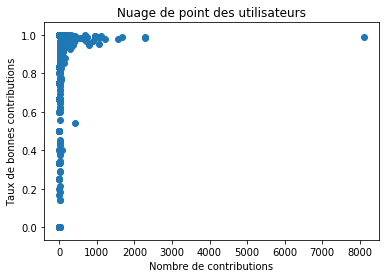

In [16]:
x = []
y = []
for user in contribs.user.unique():
    count_total = count_good_responses[user] + count_bad_responses[user]
    if count_total:
        x.append(count_total)
        y.append(count_good_responses[user] * 1. / count_total)
plt.scatter(x, y)
plt.title('Nuage de point des utilisateurs')
plt.xlabel('Nombre de contributions')
plt.ylabel('Taux de bonnes contributions')

In [17]:
nb_errors = 0
nb_correct = 0
bad_users = []
for user in contribs.user.unique():
    count_total = count_good_responses[user] + count_bad_responses[user]
    if count_total:
        user_precision = count_good_responses[user] * 1. / count_total
        if user_precision < 0.7:
            bad_users.append(user)
            nb_errors += count_bad_responses[user]
            nb_correct += count_good_responses[user]
print(nb_errors)
print(nb_correct)
print(len(bad_users))

725
560
191


In [18]:
clean_contribs = contribs[contribs.apply(lambda r: r.user not in bad_users, axis=1)]
clean_dataset = clean_contribs[contribs.label!=0]
clean_dataset = clean_dataset[features]

/home/michel/.virtualenvs/solar/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [19]:
len(clean_dataset[clean_dataset.label==-1])

1273

In [20]:
def custom_convolution(a, kernel):
    n = len(a)
    k = int((len(kernel)-1)/2)
    
    conv = np.zeros(n)
    for i in range(n):
        imin_kernel = max(0, k-i)
        imax_kernel = min(2*k+1, k+n-i)
        imin_a = max(0, i-k)
        imax_a = min(n, k+1+i)
        conv[i] = (a[imin_a:imax_a]*kernel[imin_kernel:imax_kernel]).sum() / (kernel[imin_kernel:imax_kernel].sum())
    
    return conv

sigma = 6.
kernel_size = int(math.floor(3.5*sigma))
kernel = np.exp(-np.power(np.arange(2*kernel_size+1)-kernel_size, 2.)/(2*np.power(sigma, 2.)))
kernel /= kernel.sum()

/home/michel/.virtualenvs/solar/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=100).mean()


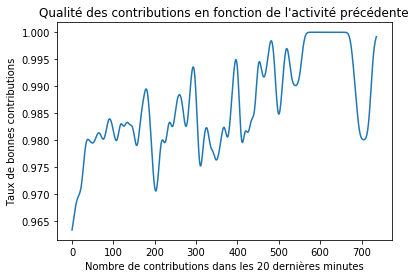

In [21]:
renormalized_labels = clean_dataset[['responses_last_20_mn', 'label']].copy()
renormalized_labels['label'] = (renormalized_labels.label + 1) / 2
renormalized_labels.sort_values(by='responses_last_20_mn', inplace=True)

renormalized_labels.label = pd.rolling_mean(renormalized_labels.label, 100)
fatigue_effect_smoothed = renormalized_labels.groupby('responses_last_20_mn')['label'].mean()
fatigue_effect_smoothed = custom_convolution(fatigue_effect_smoothed, kernel)

plt.plot(fatigue_effect_smoothed)
plt.title("Qualité des contributions en fonction de l'activité précédente")
plt.xlabel('Nombre de contributions dans les 20 dernières minutes')
plt.ylabel('Taux de bonnes contributions')

In [22]:
renormalized_labels = clean_dataset[['response_time_seconds', 'label']].copy()
renormalized_labels['label'] = (renormalized_labels.label + 1) / 2
renormalized_labels = renormalized_labels[renormalized_labels.response_time_seconds < 5]
renormalized_labels.sort_values(by='response_time_seconds', inplace=True)

renormalized_labels.label = pd.rolling_mean(renormalized_labels.label, 200)
rate = renormalized_labels.set_index('response_time_seconds')
rate.dropna(inplace=True)

/home/michel/.virtualenvs/solar/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=200).mean()


In [23]:
# gaussian smoothing
sigma = 0.1
event_times = np.array(rate.index)
n_events = len(event_times)
t = np.linspace(0, 5, 200)
n_t = len(t)
diff_t = event_times.reshape((1, n_events)) - t.reshape((n_t, 1))
weight_matrix = np.exp(-np.power(diff_t, 2.)/(2*np.power(sigma, 2.)))
weight_matrix /= weight_matrix.sum(1).reshape((n_t, 1))
rate_smoothed = np.dot(weight_matrix, np.array(rate))

In [24]:
# drop values under min t
min_t = min(event_times)
rate_smoothed[t < min_t] = np.nan

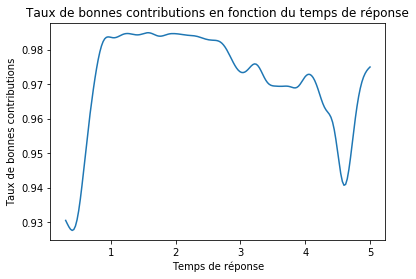

In [25]:
plt.plot(t, rate_smoothed)
plt.title('Taux de bonnes contributions en fonction du temps de réponse')
plt.ylabel('Taux de bonnes contributions')
plt.xlabel('Temps de réponse')